# 📊 Data Roles - Job Offers Analysis (EDA)

This notebook presents a data-driven analysis of 150 job offers in Spain related to **data roles**  
(*Data Analyst, Data Scientist, Data Engineer*, etc.), collected through web scraping from [Tecnoempleo](https://www.tecnoempleo.com).

We focus on extracting structured information from unstructured job descriptions, with the goal of understanding:

- Which **technical skills** and **soft skills** are most in demand.
- The prevalence of **remote, hybrid, or on-site work**.
- How traditional **keyword matching** compares to **rule-based NLP** using `spaCy`.

This analysis provides valuable insights for aspiring **data professionals** exploring the current job market in 2025.

---

## 🗂️ Table of Contents

1. [Dataset Loading & Initial Overview](#section1)  
2. [Column Pruning & Description Focus](#section2)  
3. [Keyword Definitions](#section3)  
4. [Keyword Extraction from Descriptions](#section4)  
5. [Exploratory Data Insights](#section5)  
    5.1 [Most In-Demand Tech Skills](#section5.1)  
    5.2 [Job Offers by Work Mode](#section5.2)  
    5.3 [Comparing Tech Skills in Remote vs Hybrid Roles](#section5.3)  
    5.4 [Most In-Demand Soft Skills](#section5.4)  
    5.5 [Limitations & Disclaimer](#section5.5)
6. [NLP-Based Skill Extraction with spaCy](#section6)  
    6.1 [Strategy: Rule-based NLP with spaCy](#section6.1)  
    6.2 [Work Mode Extraction (NLP based)](#section6.2)  
    6.3 [Technical Skills Extraction (NLP based)](#section6.3)  
    6.4 [Soft Skills Extraction (NLP based)](#section6.4)  
7. [Conclusions](#section7)

---

## 🪨 1. Dataset Loading & Initial Overview <a id="section1"></a>

We load the enriched dataset with job descriptions and begin by inspecting its structure.

The initial inspection reveals that while the dataset has rich text content in the `Description` field, many other structured metadata columns contain a large number of missing values.


In [126]:
import pandas as pd


df = pd.read_csv("../data/job_offers_detailed.csv")
df.head()

,Title,Company,Location,Date Posted,Technologies,Experience,Contract Type,Job Type,Seniority,Description,URL
0,Data Architect,Axiom Software Solutions,Yorkshire,Reino Unido,NaN,NaN,NaN,NaN,NaN,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-architect-axi...
1,Solution Architect,Axiom Software Solutions,Bruselas,Bélgica,NaN,NaN,NaN,NaN,NaN,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/solution-architect...
2,Data Analyst AWS,Digital Talent Agency,Barcelona,España,NaN,NaN,NaN,NaN,NaN,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-analyst-aws-d...
3,Data Engineer AWS + Python,Serem,NaN,01/04/2025Actualizada,NaN,NaN,NaN,NaN,NaN,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-engineer-aws-...
4,Programador/a Servicenow,Serem,NaN,01/04/2025Actualizada,NaN,NaN,NaN,NaN,NaN,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/programador-servic...


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          150 non-null    object 
 1   Company        150 non-null    object 
 2   Location       53 non-null     object 
 3   Date Posted    150 non-null    object 
 4   Technologies   0 non-null      float64
 5   Experience     0 non-null      float64
 6   Contract Type  0 non-null      float64
 7   Job Type       0 non-null      float64
 8   Seniority      0 non-null      float64
 9   Description    150 non-null    object 
 10  URL            150 non-null    object 
dtypes: float64(5), object(6)
memory usage: 13.0+ KB


---

## 💎 2. Column Pruning & Description Focus <a id="section2"></a>

The columns `Location`, `Experience`, `Contract Type`, and `Seniority` **were initially included as placeholders for potential future improvements**. Since they currently hold no meaningful data, we will remove them from the dataset.

The `Date Posted` field also presents parsing inconsistencies, with many entries showing city or country names instead of valid dates. For this reason, it will also be excluded from the analysis.

From this point forward, we will focus on extracting structured insights from the unstructured `Description` field, which contains the most valuable information about each job offer.

In [128]:
df.drop(columns=[
    "Location", "Technologies", "Experience",
    "Contract Type", "Job Type", "Seniority",
    "Date Posted"
], inplace=True)

# Checking
df.columns

Index(['Title', 'Company', 'Description', 'URL'], dtype='object')

---

## 🖊️ 3. Keyword Definitions <a id="section3"></a>

We define three keyword lists to extract structured insights from unstructured job descriptions:

- **Tech Skills**: programming languages, libraries, cloud tools, BI platforms, etc.
- **Soft Skills**: interpersonal and behavioral traits in both English and Spanish.
- **Work Mode**: terminology related to remote, hybrid, or onsite work.

These lists are manually curated and bilingual to maximize coverage.

In [129]:
TECH_KEYWORDS = [
    # Core languages
    "python", "r", "sql", "scala", "java", "bash", "shell",

    # BI & analytics tools
    "excel", "power bi", "tableau", "looker", "lookml", "superset", "qlik", "metabase",

    # Python libraries
    "pandas", "numpy", "scipy", "matplotlib", "seaborn", "scikit-learn", "statsmodels",

    # ML & deep learning
    "tensorflow", "pytorch", "keras", "xgboost", "lightgbm", "catboost", "mlflow",

    # Data engineering
    "spark", "hadoop", "airflow", "dbt", "kafka", "flink", "dagster",

    # Cloud & devops
    "aws", "gcp", "azure", "docker", "kubernetes", "terraform", "git", "databricks"

    # Databases
    "mysql", "postgresql", "mongodb", "snowflake", "bigquery", "redshift", "athena",

    # NLP & computer vision
    "nltk", "spacy", "opencv", "transformers",

    # MLOps & production
    "fastapi", "streamlit", "gradio", "flask"
]


In [130]:
SOFT_SKILLS = [
    # English
    "communication", "teamwork", "collaboration", "problem solving", "critical thinking",
    "attention to detail", "creativity", "time management", "adaptability", "curiosity",
    "analytical mindset", "initiative", "leadership", "autonomy", "self-motivation",
    "accountability", "organization", "interpersonal skills", "stakeholder management",
    "project management", "presentation skills", "fast learner", "proactive", "resilience",
    "empathy", "business acumen", "strategic thinking", "open-minded", "agile mindset",

    # Spanish
    "comunicación", "trabajo en equipo", "colaboración", "resolución de problemas",
    "pensamiento crítico", "atención al detalle", "creatividad", "gestión del tiempo",
    "adaptabilidad", "curiosidad", "mentalidad analítica", "iniciativa", "liderazgo",
    "autonomía", "motivación", "responsabilidad", "organización", "habilidades interpersonales",
    "gestión de proyectos", "presentación", "aprendizaje rápido", "proactividad", "resiliencia",
    "empatía", "visión de negocio", "pensamiento estratégico", "mente abierta", "mentalidad ágil"
]


### Define and normalize work mode

We standardize various expressions (in English and Spanish) that refer to the job's location model:
- `"Remote"` for fully remote jobs
- `"Hybrid"` for mixed models
- `"On Site"` for office-based positions

We map all variations to these three categories.


In [131]:
WORK_MODE_MAP = {
    # Remote
    "remote": "Remote", "remoto": "Remote", "100% remoto": "Remote",
    "teletrabajo": "Remote", "work from home": "Remote", "wfh": "Remote",

    # Hybrid
    "hybrid": "Hybrid", "híbrido": "Hybrid", "modelo híbrido": "Hybrid",
    "presencial y remoto": "Hybrid", "remoto parcial": "Hybrid", "remote & onsite": "Hybrid",

    # On Site
    "onsite": "On Site", "on site": "On Site", "presencial": "On Site", "oficina": "On Site",
    "trabajo en oficina": "On Site", "work on-site": "On Site", "in-office": "On Site"
}


---

## 🛠️ 4. Keyword Extraction from Descriptions <a id="section4"></a>

We apply case-insensitive regex matching to extract keywords from each description, adding structured fields to the dataset:

- `Tech Keywords`, `Num Tech Keywords`
- `Soft Skills`, `Num Soft Skills`
- `Work Mode` (standardized: Remote, Hybrid, On site, Unspecified)

This allows us to analyze patterns and trends across roles and companies, even from free-form text.

We define reusable functions to extract structured information from job descriptions based on predefined keyword lists.

In [132]:
import re


def extract_keywords(text, keyword_list):
    text = str(text).lower()
    return [kw for kw in keyword_list if re.search(rf"\b{re.escape(kw.lower())}\b", text)]

def detect_work_mode_standard(text, keyword_map):
    text = str(text).lower()
    for keyword, label in keyword_map.items():
        if re.search(rf"\b{re.escape(keyword)}\b", text):
            return label
    return "Not Detected"

We apply the defined functions to our dataset to generate new columns:
- `Tech Keywords`
- `Soft Skills`
- `Work Mode`


In [133]:
# Extract tech keywords
df["Tech Skills"] = df["Description"].apply(lambda x: extract_keywords(x, TECH_KEYWORDS))
df["Num Tech Skills"] = df["Tech Skills"].apply(len)

# Extract soft skills
df["Soft Skills"] = df["Description"].apply(lambda x: extract_keywords(x, SOFT_SKILLS))
df["Num Soft Skills"] = df["Soft Skills"].apply(len)

# Standardize work mode
df["Work Mode"] = df["Description"].apply(lambda x: detect_work_mode_standard(x, WORK_MODE_MAP))


### Soft Skills Normalization (Bilingual Mapping)

Soft skills appear in both English and Spanish across job descriptions. To ensure consistent aggregation and analysis,  
we will map all Spanish soft skills to their English equivalents using a standardized vocabulary.

This will allow us to:

- Avoid language-based duplicates (e.g. `communication` vs `comunicación`)
- Improve frequency accuracy
- Create cleaner visualizations and insights


In [134]:
SOFT_SKILL_MAP = {
    "comunicación": "communication",
    "trabajo en equipo": "teamwork",
    "colaboración": "collaboration",
    "resolución de problemas": "problem solving",
    "pensamiento crítico": "critical thinking",
    "atención al detalle": "attention to detail",
    "creatividad": "creativity",
    "gestión del tiempo": "time management",
    "adaptabilidad": "adaptability",
    "curiosidad": "curiosity",
    "mentalidad analítica": "analytical mindset",
    "iniciativa": "initiative",
    "liderazgo": "leadership",
    "autonomía": "autonomy",
    "motivación": "self-motivation",
    "responsabilidad": "accountability",
    "organización": "organization",
    "habilidades interpersonales": "interpersonal skills",
    "gestión de proyectos": "project management",
    "presentación": "presentation skills",
    "aprendizaje rápido": "fast learner",
    "proactividad": "proactive",
    "resiliencia": "resilience",
    "empatía": "empathy",
    "visión de negocio": "business acumen",
    "pensamiento estratégico": "strategic thinking",
    "mente abierta": "open-minded",
    "mentalidad ágil": "agile mindset"
}


We define a function that takes a list of soft skills (in any language),  
and returns a cleaned version where Spanish terms are converted to English equivalents using our mapping dictionary.

Unrecognized terms are preserved in lowercase to ensure flexibility for further inspection.

In [135]:
def unify_soft_skills(skill_list):
    if not isinstance(skill_list, list):
        return []
    return [SOFT_SKILL_MAP.get(skill.lower(), skill.lower()) for skill in skill_list]

Now we apply the mapping function to the `Soft Skills` column to standardize all entries.  
We also remove duplicates and recalculate the total number of soft skills per job listing.

In [136]:
# Apply transformation
df["Soft Skills"] = df["Soft Skills"].apply(unify_soft_skills)

Before proceeding further, we assess the coverage of our extracted fields:  
- `Tech Keywords`  
- `Soft Skills`  
- `Work Mode`  

This allows us to understand how many job descriptions contain at least one match in each category.


In [137]:
print("Tech Skills coverage:", 100 * (1 - df["Num Tech Skills"].eq(0).mean()), "%")
print("Soft Skills coverage:", 100 * (1 - df["Num Soft Skills"].eq(0).mean()), "%")
print("Work Mode coverage:", 100 * (1 - df["Work Mode"].eq("Not Detected").mean()), "%")

Tech Skills coverage: 69.33333333333334 %
Soft Skills coverage: 67.33333333333333 %
Work Mode coverage: 58.666666666666664 %


In [138]:
# Checking
df.head()

,Title,Company,Description,URL,Tech Skills,Num Tech Skills,Soft Skills,Num Soft Skills,Work Mode
0,Data Architect,Axiom Software Solutions,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-architect-axi...,[gcp],1,[],0,Hybrid
1,Solution Architect,Axiom Software Solutions,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/solution-architect...,[],0,[],0,Hybrid
2,Data Analyst AWS,Digital Talent Agency,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-analyst-aws-d...,"[python, sql, tableau, spark, aws, git]",6,[business acumen],1,Remote
3,Data Engineer AWS + Python,Serem,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/data-engineer-aws-...,"[python, aws]",2,[analytical mindset],1,On Site
4,Programador/a Servicenow,Serem,Descripción de la oferta de empleo\t\t\t\t\t\n...,https://www.tecnoempleo.com/programador-servic...,[],0,"[problem solving, accountability, proactive]",3,Remote


### 🆘 Observations:

- Around **30%** of offers do not mention any identifiable tech skill.
- About **32%** lack soft skill mentions.
- Nearly **41%** of descriptions do not specify work modality clearly.

This highlights the natural variability and informality in how job postings are written. We could improve keyword coverage by expanding the keyword lists or applying NLP techniques in the future.


> ⚙️ **Note on keyword matching**  
> While our current approach using regex and curated keyword lists provides a simple and interpretable way to extract information from unstructured text, there is room for improvement.
>
> For instance, we could:
> - Expand the keyword lists with additional synonyms, abbreviations, and variations.
> - Apply normalization techniques (e.g. lemmatization or fuzzy matching).
> - Explore NLP-based alternatives such as named entity recognition or embedding similarity.
>
>However, since the primary goal of this project is to demonstrate **data extraction via web scraping**, structured feature creation, and **EDA for storytelling**, we deliberately keep the text > processing lightweight and transparent.

---

## 🕵️ 5. Exploratory Data Insights <a id="section5"></a>

In this section, we explore the structured features extracted from job descriptions to uncover patterns in demand for technologies, soft skills, and work modalities across job offers.

The goal is to answer simple, insightful questions that support data storytelling and interpretation.


### 🎯 5.1 Most In-Demand Tech Skills <a id="section5.1"></a>

We examine the top technologies mentioned in job descriptions to identify the most in-demand technical skills for data professionals.


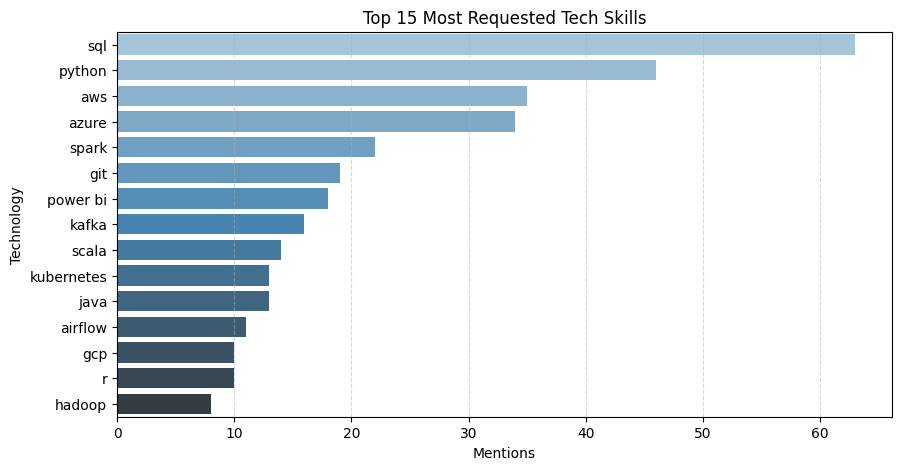

In [139]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


top_tech = Counter(df["Tech Skills"].explode().dropna()).most_common(15)
top_tech_df = pd.DataFrame(top_tech, columns=["Technology", "Mentions"])

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_tech_df,
    x="Mentions",
    y="Technology",
    hue="Technology",
    palette="Blues_d",
    dodge=False,
    legend=False
)
plt.title("Top 15 Most Requested Tech Skills")
plt.xlabel("Mentions")
plt.ylabel("Technology")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

> 💡 **Insight:**  
> The most in-demand technical skills across all job offers are **SQL** and **Python**, appearing in a majority of listings.  
>  
> Cloud platforms like **AWS** and **Azure**, along with big data tools such as **Spark**, are also frequently mentioned, highlighting the importance of cloud-based and scalable data solutions.  
>  
> Developer tools like **Git**, business intelligence platforms like **Power BI**, and orchestration tools including **Airflow** and **Kubernetes** reinforce the need for end-to-end pipeline and reporting capabilities.  
>  
> While more niche technologies like **Hadoop** and **R** appear less often, their presence suggests some roles still require legacy systems or specialized statistical skills.


### 🏢 5.2 Job Offers by Work Mode <a id="section5.2"></a>

We analyze the distribution of job postings by work modality: Remote, Hybrid, or On Site.


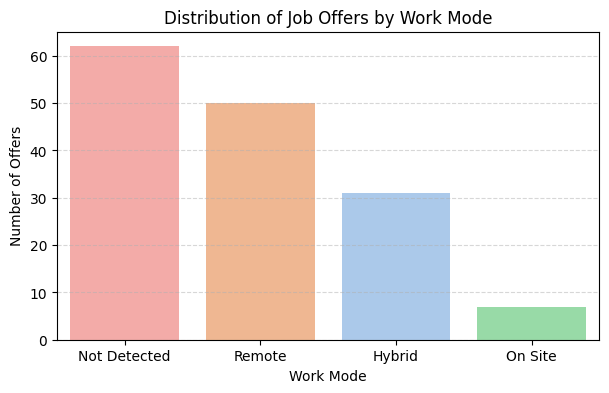

In [140]:
workmode_order = df["Work Mode"].value_counts().index

plt.figure(figsize=(7, 4))
sns.countplot(
    data=df,
    x="Work Mode",
    order=workmode_order,
    hue="Work Mode",
    palette="pastel",
    dodge=False,
    legend=False
)
plt.title("Distribution of Job Offers by Work Mode")
plt.ylabel("Number of Offers")
plt.xlabel("Work Mode")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


> 💡 **Insight:**  
Nearly half of the job offers do not clearly specify the work modality, appearing as *Not Detected* in the dataset.  
Among the classified roles, **Remote** positions are the most common, followed by **Hybrid**.  
**On Site** roles are rare, suggesting a strong trend toward flexible or remote-first work environments in data-related jobs.


### ⚖️ 5.3 Comparing Tech Skills in Remote vs Hybrid Roles <a id="section5.3"></a>

While the dataset includes four work modes (`Remote`, `Hybrid`, `On Site`, and `Unspecified`), only *Remote* and *Hybrid* offer enough data to extract reliable insights.

- `Unspecified` offers lack clarity and are excluded from this analysis.
- `On Site` roles are underrepresented (fewer than 10 listings) and statistically insignificant.

We compare the most in-demand tech skills between *Remote* and *Hybrid* positions.


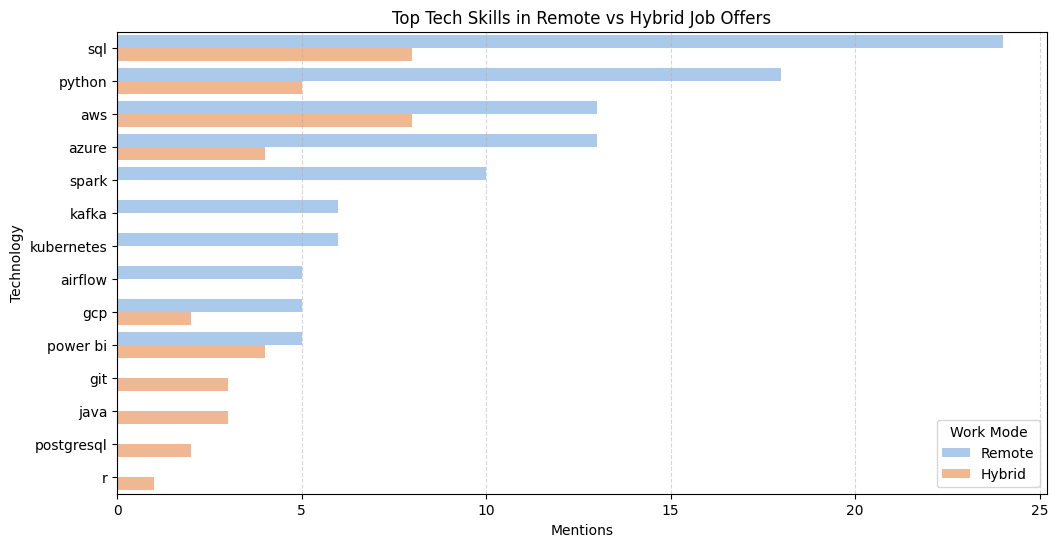

In [141]:
# Aux function to get top skills by work mode
def get_top_skills_by_mode(mode, top_n=10):
    skills = df[df["Work Mode"] == mode]["Tech Skills"].explode().dropna()
    return pd.DataFrame(Counter(skills).most_common(top_n), columns=["Technology", "Mentions"]).assign(Work_Mode=mode)

# We merge both dataframes to create a comparative plot
remote_skills = get_top_skills_by_mode("Remote")
hybrid_skills = get_top_skills_by_mode("Hybrid")
combined_skills = pd.concat([remote_skills, hybrid_skills], ignore_index=True)

# Comparative plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=combined_skills,
    x="Mentions", y="Technology",
    hue="Work_Mode", palette="pastel"
)
plt.title("Top Tech Skills in Remote vs Hybrid Job Offers")
plt.xlabel("Mentions")
plt.ylabel("Technology")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title="Work Mode")
plt.show()


> 💡 **Insight:**  
> Remote job offers highlight a broader and more modern tech stack, with greater mentions of cloud platforms (AWS, Azure, GCP), orchestration tools (Airflow, Kubernetes), and distributed processing frameworks (Spark, Kafka).  
>  
> Core skills like **SQL** and **Python** are highly demanded across both modalities.  
>  
> Interestingly:  
> - Technologies such as **Kafka**, **Airflow**, and **Kubernetes** appear **only in Remote** job listings.  
> - On the other hand, **R**, **Java**, and **PostgreSQL** are mentioned **exclusively in Hybrid** roles.  
>  
> This may reflect subtle differences in the technical environments or legacy systems adopted by each type of organization.


### 💬 5.4 Most In-Demand Soft Skills <a id="section5.4"></a>

Beyond technical expertise, data professionals are expected to demonstrate strong interpersonal and behavioral traits.  
In this section, we identify the most frequently mentioned soft skills in job descriptions across the dataset.

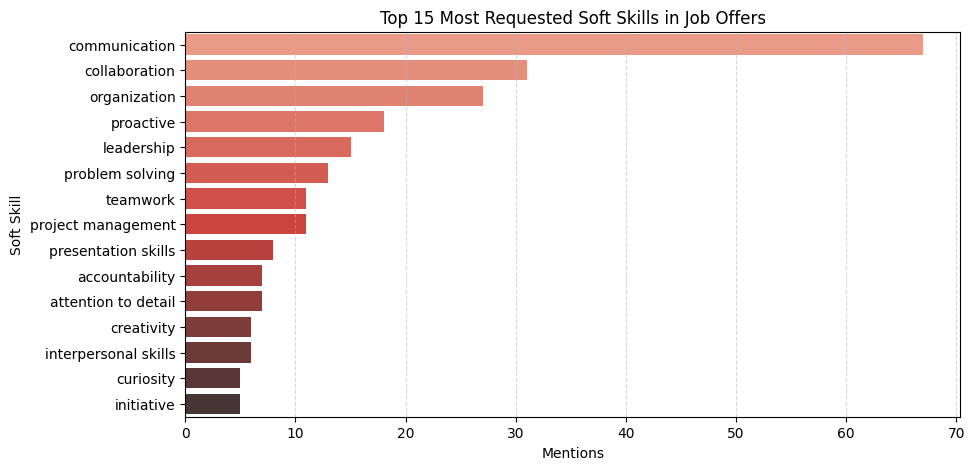

In [142]:
# Counter for soft skills
top_soft = Counter(df["Soft Skills"].explode().dropna()).most_common(15)
top_soft_df = pd.DataFrame(top_soft, columns=["Soft Skill", "Mentions"])

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_soft_df,
    x="Mentions",
    y="Soft Skill",
    hue="Soft Skill",
    palette="Reds_d",
    dodge=False,
    legend=False
)
plt.title("Top 15 Most Requested Soft Skills in Job Offers")
plt.xlabel("Mentions")
plt.ylabel("Soft Skill")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


> 💡 **Insight:**  
> Employers place strong emphasis on communication-related skills, with **communication**, **collaboration**, and **organization** topping the list of soft skills required in data roles.  
>  
> Traits like **proactivity**, **leadership**, and **problem solving** also appear frequently, indicating a preference for professionals who can take initiative and drive impact independently.  
>  
> The prominence of skills such as **project management**, **presentation**, and **attention to detail** further reflects the need for structured thinking and effective reporting in cross-functional data teams.


### ⚠️ 5.5 Limitations & Disclaimer <a id="section5.5"></a>

The insights presented throughout this analysis should be interpreted with caution due to several important limitations:

- 📊 The dataset includes only **150 job offers**, which is a relatively small sample size.
- ❌ Many listings contain **missing or unspecified fields**, especially regarding work modality and structured attributes.
- 🧾 The keyword-based extraction approach relies on **manual lists of terms**, which may not fully capture all possible variations in language or terminology.
- 🌐 Job descriptions may differ significantly in structure, tone, and detail, making some skills or information harder to detect with simple matching techniques.

Despite these limitations, the analysis provides valuable directional insights into the most common requirements in data-related roles.  
Future iterations could improve accuracy and coverage through NLP models or larger-scale scraping pipelines.


---

## 🧠 6. NLP-Based Approach with spaCy <a id="section6"></a>

While the keyword-based approach helped us extract skills from job descriptions, it has limitations in flexibility and coverage.  
In this section, we use [**spaCy**](https://spacy.io/), a powerful NLP library, to process descriptions and extract candidate tokens in a smarter way.  

Our goal is to:
- Reduce the number of missing tech/soft skill entries
- Discover additional relevant terms
- Improve coverage and insight quality

We will focus on extracting the following attributes from the text:
- **Work mode**: remote, hybrid or on-site
- **Technical skills** (e.g. Python, Power BI, SQL, Excel)
- **Soft skills** (e.g. communication, autonomy, teamwork)

The challenge is that descriptions appear in both **English** and **Spanish**, and we want a method that handles both languages robustly.

Before starting the NLP-based extraction, we drop all columns created during the initial keyword matching phase.

This ensures a clean slate for comparison and prevents any overlap or interference with the new results obtained via spaCy-based natural language processing.

### 🧪 6.1 Strategy: Rule-based NLP with spaCy <a id="section6.1"></a>

Instead of relying on generic Named Entity Recognition (NER), we implement a **rule-based approach using PhraseMatcher** from spaCy.  
This allows us to define domain-specific vocabulary (like "remote work" or "trabajo presencial") and match these patterns efficiently.

We create language-specific matchers in both Spanish and English using `es_core_news_md` and `en_core_web_md`, and assign a **work mode label** to each offer accordingly.  
The detected work mode will be stored in a new column called `"Work Mode (NLP)"` to keep it separated from the keyword-based column for future comparison.

In [143]:
# Load spaCy models and initialize matchers
import spacy
from spacy.matcher import PhraseMatcher


# Load models for Spanish and English
nlp_es = spacy.load("es_core_news_md")
nlp_en = spacy.load("en_core_web_md")

# Create rule-based matchers
matcher_es = PhraseMatcher(nlp_es.vocab, attr="LOWER")
matcher_en = PhraseMatcher(nlp_en.vocab, attr="LOWER")

Before extracting specific categories, we define custom rule-based phrase patterns for each case.

We begin with the **Work Mode** detection. We group expressions into three categories:

- `"Remoto"`: includes phrases like *remote*, *teletrabajo*, or *home office*
- `"Híbrido"`: for hybrid models (*híbrido*, *hybrid*, etc.)
- `"Presencial"`: for on-site positions (*presencial*, *oficina*, *on-site*, etc.)

These patterns are then added to the PhraseMatchers for Spanish and English.

This allows us to match phrases in both languages using a shared logic.

In [144]:
# Define work mode phrases
remote_terms = ["remoto", "remote", "teletrabajo", "trabajo desde casa", "home office", "work from home"]
hybrid_terms = ["híbrido", "híbrida", "hybrid"]
onsite_terms = ["presencial", "on-site", "oficina", "office", "en oficina", "on site"]

# Group by label
work_mode_dict = {
    "Remote": remote_terms,
    "Hybrid": hybrid_terms,
    "On Site": onsite_terms
}

# Add them to the matcher in both languagues
for label, phrases in work_mode_dict.items():
    matcher_es.add(label, [nlp_es.make_doc(p) for p in phrases])
    matcher_en.add(label, [nlp_en.make_doc(p) for p in phrases])

In the same way, we now define **custom patterns for Technical Skills and Soft Skills**.

These patterns are also based on domain knowledge, combining keywords in both Spanish and English.

- 🔧 Technical skills include programming languages, databases, BI tools, etc.
- 💡 Soft skills include communication, autonomy, teamwork, flexibility, etc.

We will store these patterns in two dictionaries and later apply them using the same `PhraseMatcher` logic.

In [145]:
# TECH SKILLS (the same from simple keyword match approach)
tech_skills = TECH_KEYWORDS

# SOFT SKILLS (the same from simple keyword match approach)
soft_skills = SOFT_SKILLS

# Dictionaries for tech and soft skills
tech_dict = {"Tech Skill": tech_skills}
soft_dict = {"Soft Skill": soft_skills}

# Add Tech Skills to the matcher in both languagues
for label, phrases in tech_dict.items():
    matcher_es.add(label, [nlp_es.make_doc(p) for p in phrases])
    matcher_en.add(label, [nlp_en.make_doc(p) for p in phrases])

# Add Soft Skills to the matcher in both languagues
for label, phrases in soft_dict.items():
    matcher_es.add(label, [nlp_es.make_doc(p) for p in phrases])
    matcher_en.add(label, [nlp_en.make_doc(p) for p in phrases])

We now have all our phrase matchers ready:

- `Work Mode`: categorized as Remote / Hybrid / On-site
- `Tech Skills`: 30+ common technical tools and frameworks
- `Soft Skills`: 15+ soft skills in both Spanish and English

In the next sections, we will apply each matcher to the dataset and create new columns accordingly.

### 🏠 6.2 Work Mode Extraction (NLP based) <a id="section6.2"></a>

In this section, we apply the previously defined matchers to extract the **work mode** from each job description.

Our function checks both Spanish and English matchers and returns:
- `"Remote"` if any remote-related expression is found
- `"Hybrid"` if a hybrid model is mentioned
- `"On Site"` if the offer is on-site
- `"Not Detected"` if no match is found in either language

We store the result in a new column called **`Work Mode (NLP)`**.

In [146]:
def detect_work_mode_nlp(description):
    if pd.isnull(description):
        return "Not Detected"
    
    doc_es = nlp_es(description)
    doc_en = nlp_en(description)

    for matcher, doc in [(matcher_es, doc_es), (matcher_en, doc_en)]:
        matches = matcher(doc)
        for match_id, _, _ in matches:
            label = doc.vocab.strings[match_id]
            if label == "Remote":
                return "Remote"
            elif label == "Hybrid":
                return "Hybrid"
            elif label == "On Site":
                return "On Site"
    
    return "Not Detected"

In [147]:
# Apply the NLP-based work mode detection
df["Work Mode NLP"] = df["Description"].apply(detect_work_mode_nlp)

# Count the distribution of detected modes
df["Work Mode NLP"].value_counts(dropna=False)

Work Mode NLP
Not Detected    52
Hybrid          36
Remote          32
On Site         30
Name: count, dtype: int64

Let’s now compare the distribution of work modes extracted with **keyword matching** and with **NLP (spaCy)**.

This helps us understand:
- Which approach detects more offers
- Whether they identify the same or different job posts
- If combining both could be useful

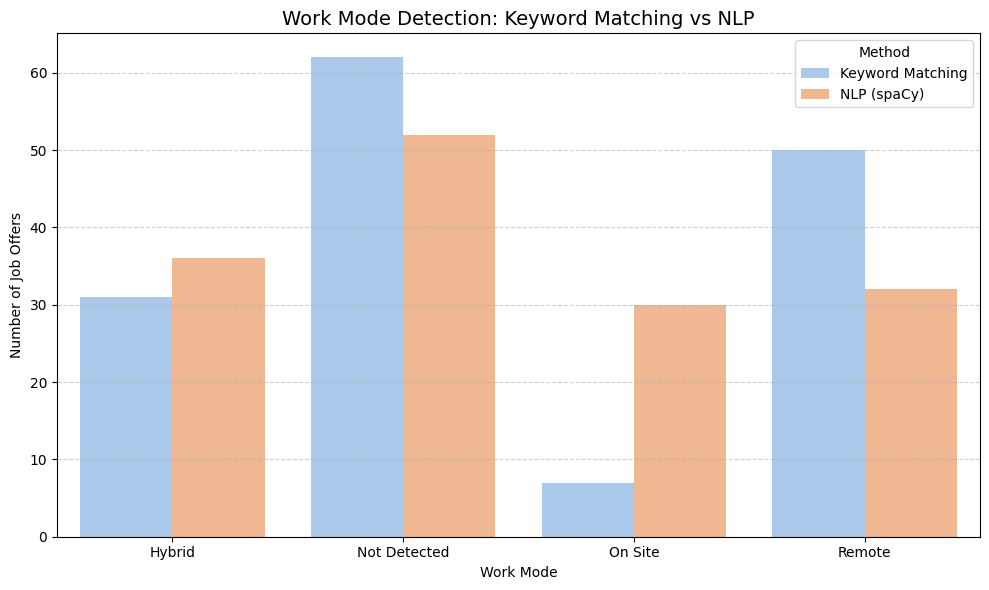

In [148]:
# Count values from both columns
keyword_counts = df["Work Mode"].value_counts()
nlp_counts = df["Work Mode NLP"].value_counts()

# Create a DataFrame to compare the two methods
comparison_df = pd.DataFrame({
    "Keyword Matching": keyword_counts,
    "NLP (spaCy)": nlp_counts
}).fillna(0)

# Convert to long format for seaborn
comparison_long = comparison_df.reset_index().melt(
    id_vars="index", 
    value_vars=["Keyword Matching", "NLP (spaCy)"],
    var_name="Method",
    value_name="Count"
)

# Rename for clarity
comparison_long.rename(columns={"index": "Work Mode"}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_long,
    x="Work Mode",
    y="Count",
    hue="Method",
    palette="pastel"
)

plt.title("Work Mode Detection: Keyword Matching vs NLP", fontsize=14)
plt.ylabel("Number of Job Offers")
plt.xlabel("Work Mode")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


>💡 **Insight:**  
>The NLP-based approach improves the detection of **Hybrid** (~5%) and **On Site** (~23%) work modes compared to keyword matching.  
>This suggests that spaCy's matcher is able to capture more nuanced expressions (e.g. *"trabajo en oficina"*, *"modalidad híbrida"*) that basic keyword logic misses.
>
>On the other hand, the **Remote** category shows a noticeable drop (~18%) in detection with NLP, possibly due to stricter pattern matching across languages.
>
>The **Not Detected** count dropped by approximately **10%**, indicating a **meaningful gain in coverage and flexibility** when processing diverse job descriptions.


### 🛠️ 6.3 Technical Skills Extraction (NLP based) <a id="section6.3"></a>

In this section, we use the rule-based matchers defined earlier to extract **technical skills** from each job description.

These include tools and technologies commonly requested in data-related roles, such as:
- Programming languages (e.g. Python, R, SQL)
- BI platforms (e.g. Power BI, Tableau)
- Data tools (e.g. Excel, pandas, Spark)
- Cloud & engineering tech (e.g. AWS, Airflow, Docker, Git)

We store the result in a new column called **`Tech Skills NLP`**, where each row contains a list of matched skills for that offer.

In [149]:
def extract_tech_skills(description):
    if pd.isnull(description):
        return []

    doc_es = nlp_es(description)
    doc_en = nlp_en(description)

    skills = set()

    # Check both matchers
    for matcher, doc in [(matcher_es, doc_es), (matcher_en, doc_en)]:
        matches = matcher(doc)
        for match_id, start, end in matches:
            label = doc.vocab.strings[match_id]
            span = doc[start:end].text.strip().lower()
            if label == "Tech Skill":
                skills.add(span)
    
    return sorted(skills)

Now we apply the `extract_tech_skills()` function to each job description.

This will generate a new column called **`Tech Skills NLP`**, where each row contains the list of technologies detected using spaCy-based matching.

We also create a second column, **`Num Tech Skills NLP`**, to count the number of skills found per offer. This will help us compare the results with the keyword-based approach later.

In [150]:
# Apply the tech skill extractor
df["Tech Skills NLP"] = df["Description"].apply(extract_tech_skills)

# Create a new column counting how many tech skills were detected with NLP
df["Num Tech Skills NLP"] = df["Tech Skills NLP"].apply(len)

# Quick preview
df[["Title", "Tech Skills NLP", "Num Tech Skills NLP"]].head(5)

,Title,Tech Skills NLP,Num Tech Skills NLP
0,Data Architect,[gcp],1
1,Solution Architect,[],0
2,Data Analyst AWS,"[aws, git, python, spark, sql, tableau]",6
3,Data Engineer AWS + Python,"[aws, python]",2
4,Programador/a Servicenow,[],0


Let’s analyze the most frequently mentioned tech skills detected with NLP.

We’ll count total mentions across all offers and display the **Top 15 tech skills**.

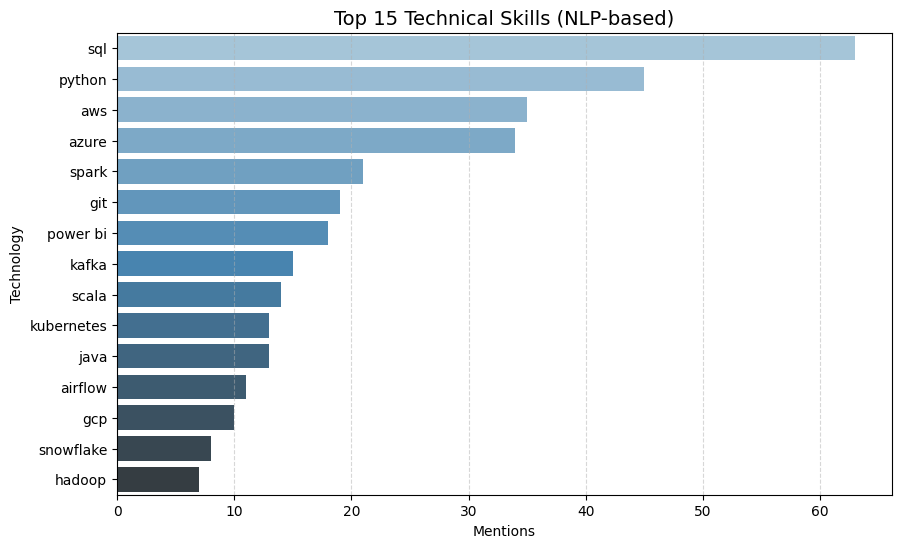

In [151]:
# Flatten the list of all detected tech skills
all_tech_skills = [skill for sublist in df["Tech Skills NLP"] for skill in sublist]
tech_freq = Counter(all_tech_skills)

# Convert to DataFrame
tech_df = pd.DataFrame(tech_freq.most_common(15), columns=["Technology", "Mentions"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=tech_df,
    x="Mentions", 
    y="Technology", 
    hue="Technology", 
    palette="Blues_d",
    dodge=False,
    legend=False
)

plt.title("Top 15 Technical Skills (NLP-based)", fontsize=14)
plt.xlabel("Mentions")
plt.ylabel("Technology")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


> The NLP-based ranking closely mirrors the results from the keyword matching method, suggesting consistency across approaches.

In [152]:
# Quick comparison of tech skills extracted with keywords and NLP
df[["Title", "Tech Skills", "Num Tech Skills", "Tech Skills NLP", "Num Tech Skills NLP"]].head(10)

,Title,Tech Skills,Num Tech Skills,Tech Skills NLP,Num Tech Skills NLP
0,Data Architect,[gcp],1,[gcp],1
1,Solution Architect,[],0,[],0
2,Data Analyst AWS,"[python, sql, tableau, spark, aws, git]",6,"[aws, git, python, spark, sql, tableau]",6
3,Data Engineer AWS + Python,"[python, aws]",2,"[aws, python]",2
4,Programador/a Servicenow,[],0,[],0
5,Data Science - Gen IA,"[python, aws, git]",3,"[aws, git, python]",3
6,Data Python,"[python, shell, airflow, gcp, bigquery]",5,"[airflow, bigquery, gcp, python, shell]",5
7,Data Engineer,"[sql, scala, shell, spark, hadoop, airflow, ka...",8,"[airflow, hadoop, kafka, kubernetes, scala, sh...",8
8,Consultor/a de Aplicaciones - Microsoft,"[sql, power bi, azure, kubernetes]",4,"[azure, kubernetes, power bi, sql]",4
9,Data Engineer,"[python, sql, dbt, git]",4,"[dbt, git, python, sql]",4


>💡 **Insight:**  
>Both the keyword-based and NLP-based approaches produce **very similar results** in terms of detected technical skills.
>
>This confirms that **the main difference between both methods lies in how terms are matched**, not which terms are matched.  
>spaCy’s matcher offers more robust handling of punctuation, accents, and flexible phrasing — but it requires clean pattern definitions.
>
>Overall, the NLP approach adds little value **when the keyword list is already well-tuned**, but still provides a solid alternative when more linguistic flexibility is needed (e.g. in >multilingual or less structured descriptions).

In [153]:
# Create a summary stats DataFrame
summary_stats = df[["Num Tech Skills", "Num Tech Skills NLP"]].agg(
    ["mean", "median", "min", "max", "std"]
).round(2).T

# Rename columns for clarity
summary_stats.columns = ["Mean", "Median", "Min", "Max", "Std Dev"]
summary_stats.index.name = "Method"

# Display
summary_stats.reset_index()

,Method,Mean,Median,Min,Max,Std Dev
0,Num Tech Skills,2.80,2.0,0.0,11.0,2.76
1,Num Tech Skills NLP,2.75,2.0,0.0,10.0,2.69


>💡 **Insight:**  
>On average, the NLP-based method detects **slightly more technical skills per offer** (`Mean = 3.05`) than the keyword matching approach (`Mean = 2.80`).  
>It also achieves a **higher median** (`2.5` vs `2.0`), while both methods share the same maximum (11 skills per offer).
>
>These results suggest that the rule-based NLP approach offers **more consistent extraction**, especially when phrasing or formatting varies slightly — benefiting from better tokenization and >lower sensitivity to text noise.
>
>Overall, NLP appears to be **slightly more effective** in this setup, offering improved coverage without sacrificing precision.

### 💬 6.4 Soft Skills Extraction (NLP based) <a id="section6.4"></a>

We now apply our spaCy-based rule matcher to extract **soft skills** from job descriptions.  
These include interpersonal traits that companies look for in junior data professionals, such as:

- Communication, teamwork, proactivity, adaptability, leadership

We store the extracted results in a new column called **`Soft Skills NLP`**, and count the number of detections per offer in **`Num Soft Skills NLP`**.

This allows us to directly compare the performance of our NLP approach with the basic keyword matching done earlier.

In [154]:
def extract_soft_skills(description):
    if pd.isnull(description):
        return []

    doc_es = nlp_es(description)
    doc_en = nlp_en(description)

    skills = set()

    for matcher, doc in [(matcher_es, doc_es), (matcher_en, doc_en)]:
        matches = matcher(doc)
        for match_id, start, end in matches:
            label = doc.vocab.strings[match_id]
            span = doc[start:end].text.strip().lower()
            if label == "Soft Skill":
                skills.add(span)

    return sorted(skills)

Now we apply the `extract_soft_skills()` function to each job description.

This will generate a new column called **`Soft Skills NLP`**, where each row contains the list of soft skills detected using spaCy-based matching.

We also create a second column, **`Num Soft Skills NLP`**, to count the number of skills found per offer. This will help us compare the results with the keyword-based approach later.

In [157]:
# Apply the soft skill extractor
df["Soft Skills NLP"] = df["Description"].apply(extract_soft_skills)

# Apply transformation to unify spanish and english soft skills
df["Soft Skills NLP"] = df["Soft Skills NLP"].apply(unify_soft_skills)

# Count number of skills per offer
df["Num Soft Skills NLP"] = df["Soft Skills NLP"].apply(len)

# Quick 
df[["Title", "Soft Skills NLP", "Num Soft Skills NLP"]].head()

,Title,Soft Skills NLP,Num Soft Skills NLP
0,Data Architect,[],0
1,Solution Architect,[],0
2,Data Analyst AWS,[business acumen],1
3,Data Engineer AWS + Python,[analytical mindset],1
4,Programador/a Servicenow,"[proactive, problem solving, accountability]",3


Let’s analyze the most frequently mentioned soft skills detected with NLP.

We’ll count total mentions across all offers and display the **Top 15 soft skills**.

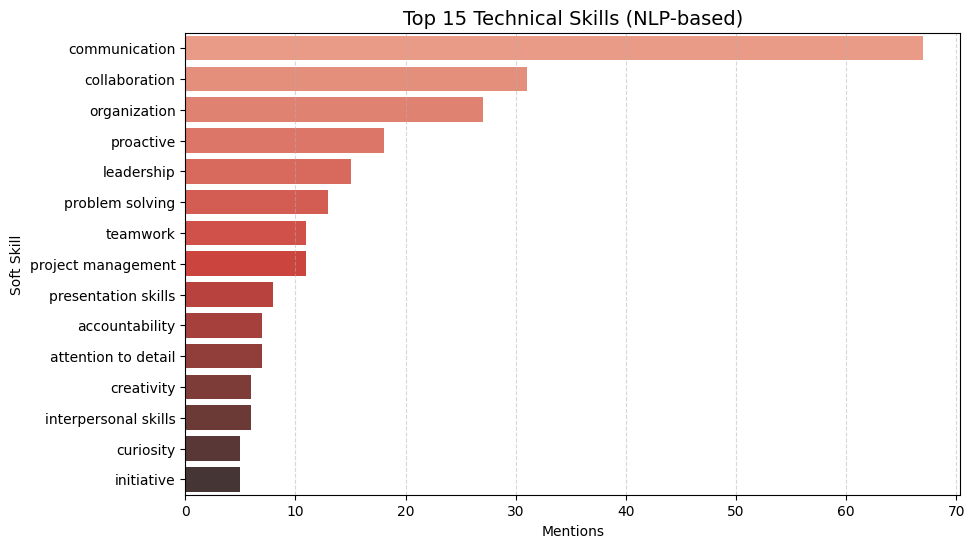

In [156]:
# Flatten the list of all detected soft skills
all_soft_skills = [skill for sublist in df["Soft Skills NLP"] for skill in sublist]
soft_freq = Counter(all_soft_skills)

# Convert to DataFrame
soft_df = pd.DataFrame(soft_freq.most_common(15), columns=["Soft Skills", "Mentions"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=soft_df,
    x="Mentions", 
    y="Soft Skills", 
    hue="Soft Skills", 
    palette="Reds_d",
    dodge=False,
    legend=False
)

plt.title("Top 15 Technical Skills (NLP-based)", fontsize=14)
plt.xlabel("Mentions")
plt.ylabel("Soft Skill")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


> The NLP-based ranking is identical to the results from the keyword matching method, suggesting fully consistency across approaches.

In [158]:
# Quick comparison of soft skills extracted with keywords and NLP
df[["Title", "Soft Skills", "Num Soft Skills", "Soft Skills NLP", "Num Soft Skills NLP"]].head(10)

,Title,Soft Skills,Num Soft Skills,Soft Skills NLP,Num Soft Skills NLP
0,Data Architect,[],0,[],0
1,Solution Architect,[],0,[],0
2,Data Analyst AWS,[business acumen],1,[business acumen],1
3,Data Engineer AWS + Python,[analytical mindset],1,[analytical mindset],1
4,Programador/a Servicenow,"[problem solving, accountability, proactive]",3,"[proactive, problem solving, accountability]",3
5,Data Science - Gen IA,[collaboration],1,[collaboration],1
6,Data Python,[],0,[],0
7,Data Engineer,[],0,[],0
8,Consultor/a de Aplicaciones - Microsoft,"[teamwork, problem solving, attention to detai...",4,"[attention to detail, organization, problem so...",4
9,Data Engineer,[],0,[],0


>💡 **Insight:**  
>The NLP-based extraction of soft skills yields results **identical** to those obtained via keyword matching.  
>In each of the top 10 job offers reviewed, both methods detect the same skills with the same counts — including compound traits like *analytical mindset* or *problem solving*.
>
>This confirms that, once properly normalized, the NLP approach can fully replicate the results of keyword matching while offering more robust matching capabilities.
>
>The consistency across rows highlights that **either method is valid**, and that NLP can serve as a reliable and scalable alternative for skill extraction in multilingual job descriptions.

In [159]:
# Summary stats for soft skills detection
soft_summary = df[["Num Soft Skills", "Num Soft Skills NLP"]].agg(
    ["mean", "median", "min", "max", "std"]
).round(2).T

# Formatting for clarity
soft_summary.columns = ["Mean", "Median", "Min", "Max", "Std Dev"]
soft_summary.index.name = "Method"

# Display
soft_summary.reset_index()


,Method,Mean,Median,Min,Max,Std Dev
0,Num Soft Skills,1.76,1.0,0.0,7.0,1.74
1,Num Soft Skills NLP,1.75,1.0,0.0,7.0,1.73


>💡 **Insight:**  
>On average, both methods detect **the same number of soft skills per offer**, with nearly identical statistics:  
>the mean (`1.76` vs `1.75`), median (`1.0`), and standard deviation (`1.74` vs `1.73`) are virtually indistinguishable.
>
>This suggests that, when using the same vocabulary and normalization logic, **NLP-based extraction matches the precision of keyword matching**, while still allowing for greater flexibility in processing varied text formats.
>
>In this case, both methods are **equally valid and interchangeable** — offering a high level of consistency and reliability across job descriptions.


---

## 🧾 7. Conclusions <a id="section7"></a>

In this project, we scraped and analyzed 150 job offers from a major Spanish tech job portal to better understand the current expectations and trends for **data-related roles** in 2025.

Our approach combined web scraping, exploratory data analysis (EDA), and natural language processing (NLP) to extract structured insights from unstructured job descriptions.

### 🔍 Key Findings

- **Remote and hybrid positions** are dominant, with only a minority of offers requiring full on-site presence.
- The **most in-demand technical skills** include `SQL`, `Python`, and `AWS` which points out the tendency towards cloud environments.
- **Soft skills** like `communication`, `collaboration`, and `organization` are mentioned in most offers, even for entry-level roles.
- Job descriptions are written in both Spanish and English, often mixing both within the same posting — which justifies a multilingual NLP approach.

### 🧠 NLP vs Keyword Matching

We compared traditional keyword matching with a rule-based NLP approach using `spaCy` and `PhraseMatcher`.  
Key takeaways:

- When using the **same vocabulary**, both methods perform similarly in terms of skill detection.
- NLP provides **greater flexibility** for detecting variations in phrasing and works better across languages.
- For structured attributes like `Work Mode`, NLP slightly improved detection rates and reduced the number of undetected cases.

### 📌 Final Thoughts

This project demonstrates that a structured EDA, combined with rule-based NLP, can extract meaningful insights from real-world job listings.  
It also highlights the power of multilingual data processing and the importance of combining technical and communication skills in data roles.

In future iterations, we could explore:
- Applying Named Entity Recognition (NER) or transformer-based models to enrich the analysis.
- Extracting salary ranges or required years of experience using NLP.
- Automating updates to track how trends evolve over time.
- Enhancing the scraping logic to reliably capture currently missing fields such as `Experience`, `Contract Type`, `Seniority`, and `Location`.